In [1]:
import vaex
import numpy as np
from matplotlib import pyplot as plt
from os.path import join, abspath
import sys
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from os import pardir

In [2]:
root_dir = abspath(pardir)
root_dir

'/home2/s20321005/Thesis-Project'

In [3]:
if root_dir not in sys.path:
    sys.path.append(root_dir)
sys.path

['/home2/s20321005/Thesis-Project/4_Gravity',
 '/home2/s20321005/.conda/envs/vaex/lib/python38.zip',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8/lib-dynload',
 '',
 '/home2/s20321005/.local/lib/python3.8/site-packages',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8/site-packages',
 '/home2/s20321005/Thesis-Project']

In [4]:
from utils import safe_mkdir

In [5]:
root_data_dir = abspath(join(pardir, "Data"))
root_data_dir 

'/home2/s20321005/Thesis-Project/Data'

## Math

The possion equation for MOND
\begin{aligned}
  \nabla \cdot \left[ \mu \left( \frac{|\nabla \Phi|}{a_0} \right) \nabla \Phi \right] = 4\pi G\rho (z,r,\phi)
\end{aligned}

where for $x \gg 1 \Rightarrow \mu (x) \approx 1$ and for $x \ll 1 \Rightarrow \mu (x) \approx x$

Assume axisymmetric potential, and can be decoupled
\begin{aligned}
  \Phi(z, r, \phi) =  \Phi(z, r) =  \Phi_z(z) + \Phi_r(r)
\end{aligned}

Therefore
\begin{aligned}
  \nabla \Phi &= \frac{\partial \Phi_z}{\partial z}\hat{z} + \frac{\partial \Phi_r}{\partial r}\hat{r}\\
  &= -K_z\hat{z} - F_r\hat{r} 
\end{aligned}

for $r=R_\odot$ and $|z|<<h_z$ ($h_z$ is some kind of scale height), $|\nabla \Phi| \approx F_r(R_\odot)$

Therefore, for $r$ around $R_\odot$, the value of $|\nabla \Phi|$ is constant, and can be move out from the divergence operator

\begin{aligned}
  \mu \left( \frac{|\nabla \Phi|}{a_0} \right) \nabla \cdot  (\nabla \Phi)  &= 4\pi G\rho (z) \\
  \nabla^2 \Phi  &= 4\pi G\rho (z)\frac{1}{\mu \left( \frac{|\nabla \Phi|}{a_0} \right) } \\
  \nabla^2 \Phi  &= 4\pi G\rho' (z)\\
\end{aligned}



Where $\rho' = \rho (z) \frac{1}{\mu \left( \frac{|\nabla \Phi|}{a_0} \right) }=\rho(z)/\mu_0$

we need to estimate the value of $|\nabla \Phi|$ in the vicinity of the sun. This value can be calculated from $LSR$ centrifetal acceleration.

\begin{aligned}
  |\nabla \Phi| &= \frac{\Theta_0^2}{R_\odot}
\end{aligned}
This paper (https://arxiv.org/pdf/1401.5377.pdf paper) gives the values of $\Theta_0$ and $R_\odot$.

\begin{aligned}
  \Theta_0 &= 240\pm8 \textup{ km s}^{-1} \\
  R_\odot &= 8.34\pm0.16 \textup{ kpc}
\end{aligned}
So
\begin{aligned}
  |\nabla \Phi| &= (2.24\pm0.02)\times 10^{-10} \textup{ m s}^{-2} \\
  \mu &= 1.0\pm0.1
\end{aligned}

Where the error is calculated below
\begin{aligned}
    \sigma_{|\nabla \Phi|}^2 &= \left(\frac{\partial |\nabla \Phi|}{\partial \Theta_0}\right)^2\sigma_{\Theta_0}^2  + \left(\frac{\partial |\nabla \Phi|}{\partial R_\odot}\right)^2\sigma_{R_\odot}^2 \\
    \sigma_{|\nabla \Phi|}^2 &= \left(\frac{2\Theta_0}{R_\odot}\right)^2\sigma_{\Theta_0}^2  + \left(\frac{\Theta_0^2}{R_\odot^2}\right)^2\sigma_{R_\odot}^2 \\
    \left(\frac{\sigma_{|\nabla \Phi|}}{|\nabla \Phi|}\right)^2 &= \left(\frac{2\sigma_{\Theta_0}}{\Theta_0}\right)^2  + \left(\frac{\sigma_{R_\odot}}{R_\odot}\right)^2 \\
\end{aligned}

The current best value of $a_0$ is around $1.2\times 10^{-10} \textup{ m s}^{-2}$

We can let $\mu_0$ be a free parameter, and fit the data to get the best value of $\mu_0$, then propagate to get the value of $a_0$ based ont hte interpolation function $\mu (x)$

We will use simple and standard interpolation functions

**Simple**
\begin{aligned}
    \mu(x) = \frac{x}{1+x}
\end{aligned}

**Standard**
\begin{aligned}
    \mu(x) = \sqrt{\frac{x^2}{1+x^2}}
\end{aligned}

For both interpolation functions, the value of $\mu_0$ is approximaterly
\begin{aligned}
    \mu_0 = \begin{cases}
    0.65 & \text{for simple} \\
    0.88 & \text{for standard}
    \end{cases}
\end{aligned}

## 1 Component

In [6]:
def rho_tot1(z, phi, rho1, sigmaz1, mu0=0.7, R=3.4E-3):
    return rho1*np.exp(-phi/sigmaz1**2)/mu0

def f1(u, z, rho1, sigmaz1, mu0=0.7, R=3.4E-3):
    G = 4.30091E-3 # pc/M_sun (km/s)^2
    return (u[1], 4*np.pi*G*rho_tot1(z, u[0], rho1, sigmaz1, mu0, R))

In [7]:
# Test
phi0 = 0 # (km/s)^2
Kz0 = 0 # pc (km/s)^2

y0 = [Kz0, phi0]
zs = np.linspace(0, 1000, 1000)

rho1 = 0.0104 # Msun/pc^3
sigmaz1 = 3.7 # km/s
mu0 = 0.7
R = 3.4E-3 # Msun/pc^3
us = odeint(f1, y0, zs, args=(rho1, sigmaz1, mu0, R))

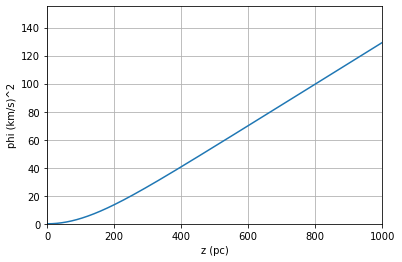

In [8]:
phi = us[:, 0]
plt.plot(zs, phi)
plt.xlabel("z (pc)")
plt.ylabel("phi (km/s)^2")
plt.xlim(0, zs[-1])
plt.ylim(0, phi[-1]*1.2)
plt.grid()

(0.0, 0.17792360561920426)

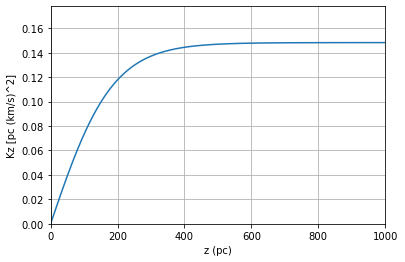

In [9]:
Kz = us[:, 1]
plt.plot(zs, Kz)
plt.xlabel("z (pc)")
plt.ylabel("Kz [pc (km/s)^2]")
plt.grid()
plt.xlim(0, zs[-1])
plt.ylim(0, Kz[-1]*1.2)

## Multi-components

In [10]:
def frho(rho0, phi, sigmaz ):
    return rho0*np.exp(-phi/sigmaz**2)

def rho_tot(z, phi, rhos, sigmaz, mu0=0.7, R=3.4E-3):
    rho = np.array(list(map(lambda par: frho(par[0], phi, par[1]), zip(rhos, sigmaz))))
    return rho.sum()/mu0 - R

def f(u, z, rhos, sigmaz, mu0=0.7, R=3.4E-3):
    G = 4.30091E-3 # pc/M_sun (km/s)^2
    return (u[1], 4*np.pi*G*rho_tot(z, u[0], rhos, sigmaz, mu0, R))

In [17]:
phi0 = 0 # (km/s)^2
Kz0 = 0 # pc (km/s)^2

y0 = [Kz0, phi0]
zs = np.linspace(0, 200, 1000)

rhos = np.array([0.0104, 0.0277, 0.0073]) # Msun/pc^3
sigmaz = np.array([3.7, 7.1, 22.1]) # km/s
mu0 = 0.1
R = 0 # 3.4E-3 # Msun/pc^3
us = odeint(f, y0, zs, args=(rhos, sigmaz, mu0, R))

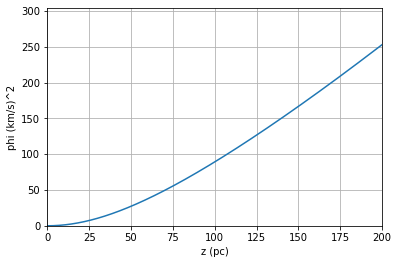

In [18]:
phi = us[:, 0]
plt.plot(zs, phi)
plt.xlabel("z (pc)")
plt.ylabel("phi (km/s)^2")
plt.xlim(0, zs[-1])
plt.ylim(0, phi[-1]*1.2)
plt.grid()

(0.0, 2.150456252533618)

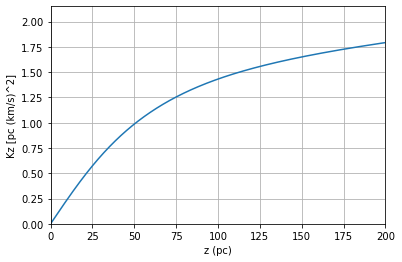

In [19]:
Kz = us[:, 1]
plt.plot(zs, Kz)
plt.xlabel("z (pc)")
plt.ylabel("Kz [pc (km/s)^2]")
plt.grid()
plt.xlim(0, zs[-1])
plt.ylim(0, Kz[-1]*1.2)

$\Phi(z)$ for all $z$ and if the middle planet is at $z_{0}$

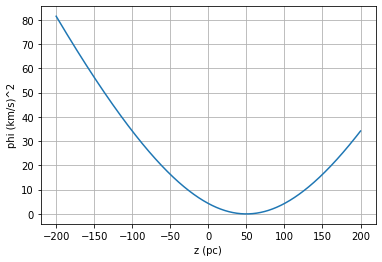

In [20]:
phi0 = 0 # (km/s)^2
Kz0 = 0 # pc (km/s)^2

y0 = [Kz0, phi0]
zmax = 200

rhos = np.array([0.0104, 0.0277, 0.0073]) # Msun/pc^3
sigmaz = np.array([3.7, 7.1, 22.1]) # km/s
mu0 = 0.7
R = 0 # 3.4E-3 # Msun/pc^3
z0 = 50

zs = np.linspace(0, zmax+np.abs(z0), 1000)
us = odeint(f, y0, zs, args=(rhos, sigmaz, mu0, R))

phi = us[:, 0]

phi_interp = interp1d(zs, phi, kind='cubic')
phi_z = lambda z, z0: phi_interp(np.abs(z-z0))

zs = np.linspace(-200, 200, 1000)
plt.plot(zs, phi_z(zs, z0))
plt.xlabel("z (pc)")
plt.ylabel("phi (km/s)^2")
plt.grid()
plt.show()

# Number density

Eq (3.4) from [Schutz et. al (2019)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.121.081101)

\begin{aligned}
  \nu(z) &= \nu_0 \int_{\sqrt{2\Phi(z)}}^\infty \frac{2f_{0}(|w|)w \text{ d}w}{\sqrt{w^2-2\Phi(z)}}
\end{aligned}
and $f_{0}(|w|)$ is modelled as gaussian with zero mean and some std $\sigma_w$
\begin{aligned}
  f_{0}(|w|) \approx \mathcal{N}(|w|; 0, \sigma_w)
\end{aligned}

Integrated, becomes
\begin{aligned}
  \nu(z) &= \nu_0\exp{\left(-\frac{\Phi(z)}{\sigma^2_w}\right)}
\end{aligned}

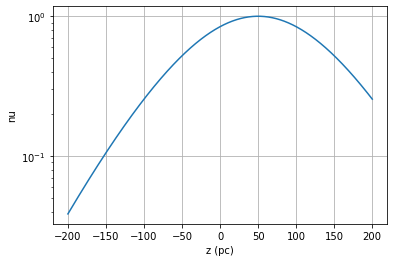

In [21]:
nu0 = 1
sigma_w = 5
nu = nu0*np.exp(-phi_z(zs, z0)/sigma_w**2)

plt.plot(zs, nu)
plt.xlabel("z (pc)")
plt.ylabel("nu")
plt.yscale("log")
plt.grid()
plt.show()

What if $f_0$ is a mixture of gaussians?
\begin{aligned}
  f_{0}(|w|) \approx \sum_i^Na_i\mathcal{N}(|w|; \mu_i, \sigma_i)
\end{aligned}

Where
\begin{align*}
 \int_{-\infty}^\infty f_{0}(|w|) \text{ d}w &= 1 \\
 \int_{-\infty}^\infty \sum_i^Na_i\mathcal{N}(|w|; \mu_i, \sigma_i) &=  1\\
 \sum_i^N a_i\int_{-\infty}^\infty \mathcal{N}(|w|; \mu_i, \sigma_i) &=  1\\
 \sum_i^N a_i &=  1\\
\end{align*}

Then, $\nu(z)$ becomes
\begin{aligned}
  \nu(z) &= \nu_0\sum_i^N\left[a_i\exp{\left(-\frac{\Phi(z)}{\sigma^2_{w,i}}\right)}\right]
\end{aligned}

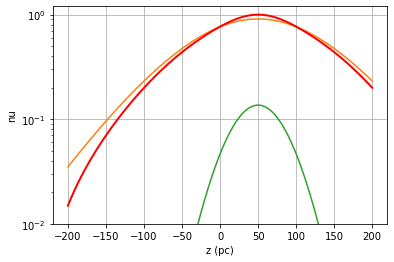

In [22]:
nu0 = 1
sigma_w = np.vstack(np.array([10, 5, 2]))
a_raw = np.vstack(np.array([-0.1, 2, 0.3]))
a = a_raw/np.sum(a_raw)

nu = nu0*np.sum(a*np.exp(-phi_z(zs, z0)/sigma_w**2), axis=0)

for ai, sigma_wi in zip(a, sigma_w):
    plt.plot(zs, nu0*ai*np.exp(-phi_z(zs, z0)/sigma_wi**2))
plt.xlabel("z (pc)")
plt.ylabel("nu")
plt.plot(zs, nu, c="r", lw=2)
plt.ylim(1E-2, nu0*1.2)
plt.yscale("log")
plt.grid()
plt.show()

# All Components

In [23]:
name = "Baryon"
data_dir = join(root_data_dir, name)
data_dir

'/home2/s20321005/Thesis-Project/Data/Baryon'

In [24]:
# load baryons components
df_baryon = vaex.open(join(data_dir, "baryon.hdf5"))
df_baryon

#,components,rho,e_rho,sigma_z,e_sigma_z
0,Molecular gas (H2),0.0104,0.00312,3.7,0.2
1,Cold atomic gas (HI(1)),0.0277,0.00554,7.1,0.5
2,Warm atomic gas (HI(2)),0.0073,0.0007,22.1,2.4
3,Hot ionized gas (HII),0.0005,3e-05,39.0,4.0
4,Giant stars,0.0006,6e-05,15.5,1.6
...,...,...,...,...,...
7,4 < MV < 5,0.0029,0.00029,18.0,1.8
8,5 < MV < 8,0.0072,0.00072,18.5,1.9
9,MV > 8,0.0216,0.0028,18.5,4.0
10,White dwarfs,0.0056,0.001,20.0,5.0


In [26]:
rhos = df_baryon["rho"].to_numpy()  # Msun/pc^3
sigmaz = df_baryon["sigma_z"].to_numpy() # km/s

# test the following dark values
mu0 = 0.7
nu0 = 1

# initial values
phi0 = 0 # (km/s)^2
Kz0 = 0 # pc (km/s)^2
R = 3.4E-3 
z0 = -50 # pc
zmax = 200 # pc
y0 = [Kz0, phi0]
zs = np.linspace(0, zmax+abs(z0), 1000)
us = odeint(f, y0, zs, args=(rhos, sigmaz, mu0, R))

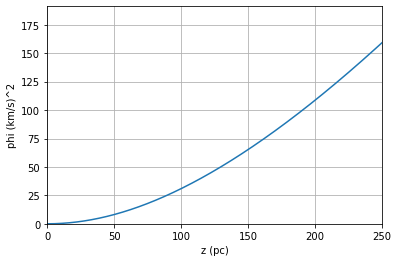

In [27]:
phi = us[:, 0]
plt.plot(zs, phi)
plt.xlabel("z (pc)")
plt.ylabel("phi (km/s)^2")
plt.xlim(0, zs[-1])
plt.ylim(0, phi[-1]*1.2)
plt.grid()

(0.0, 1.2892030367816554)

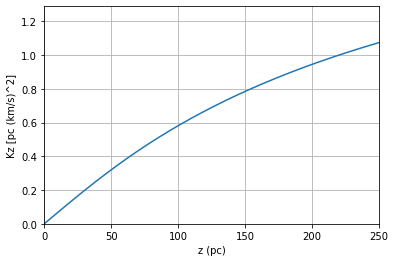

In [28]:
Kz = us[:, 1]
plt.plot(zs, Kz)
plt.xlabel("z (pc)")
plt.ylabel("Kz [pc (km/s)^2]")
plt.grid()
plt.xlim(0, zs[-1])
plt.ylim(0, Kz[-1]*1.2)

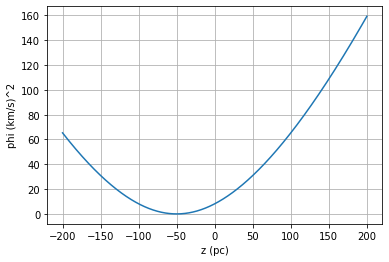

In [29]:
phi = us[:, 0]

phi_interp = interp1d(zs, phi, kind='cubic')
phi_z = lambda z, z0: phi_interp(np.abs(z-z0))

zs = np.linspace(-200, 200, 1000)
plt.plot(zs, phi_z(zs, z0))
plt.xlabel("z (pc)")
plt.ylabel("phi (km/s)^2")
plt.grid()
plt.show()

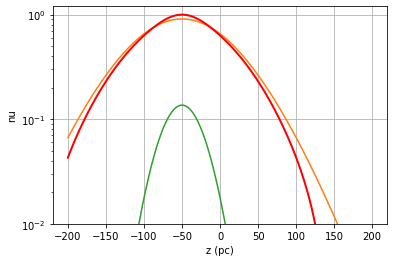

In [30]:
nu0 = 1
sigma_w = np.vstack(np.array([10, 5, 2]))
a_raw = np.vstack(np.array([-0.1, 2, 0.3]))
a = a_raw/np.sum(a_raw)

nu = nu0*np.sum(a*np.exp(-phi_z(zs, z0)/sigma_w**2), axis=0)

for ai, sigma_wi in zip(a, sigma_w):
    plt.plot(zs, nu0*ai*np.exp(-phi_z(zs, z0)/sigma_wi**2))
plt.xlabel("z (pc)")
plt.ylabel("nu")
plt.plot(zs, nu, c="r", lw=2)
plt.ylim(1E-2*nu0, nu0*1.2)
plt.yscale("log")
plt.grid()
plt.show()

Compiling and creating $\nu^{\text{mod}}(\theta)$ function

all in one

In [34]:
from operator import itemgetter
from scipy.interpolate import interp1d
import numpy as np
from scipy.integrate import odeint

def frho(rho0, phi, sigmaz ):
    return rho0*np.exp(-phi/sigmaz**2)

def rho_tot(z, phi, rhos, sigmaz, mu0=0.7, R=3.4E-3):
    rho = np.array(list(map(lambda par: frho(par[0], phi, par[1]), zip(rhos, sigmaz))))
    return rho.sum()/mu0 - R

def f(u, z, rhos, sigmaz, mu0=0.7, R=3.4E-3):
    G = 4.30091E-3 # pc/M_sun (km/s)^2
    return (u[1], 4*np.pi*G*rho_tot(z, u[0], rhos, sigmaz, mu0, R))

def phi_mond(zz, **theta):
    args = ('rhos', 'sigmaz', 'mu0', 'zsun', 'R')
    rhos, sigmaz, mu0, zsun, R = itemgetter(*args)(theta)
    res = 1000
    if 'res' in theta:
        res = theta['res']
    phi0 = 0 # (km/s)^2
    Kz0 = 0 # pc (km/s)^2

    y0 = [Kz0, phi0]
    zmax = np.max(np.abs(zz+zsun))
    zs = np.linspace(0, zmax, res)
    us = odeint(f, y0, zs, args=(rhos, sigmaz, mu0, R))
    phi = us[:, 0]
    phi_interp = interp1d(zs, phi, kind='cubic')
    phi_z = lambda z, zsun: phi_interp(np.abs(z+zsun))
    return phi_z(zz, zsun)

def nu_mond(zz, **theta):
    args = ('sigma_w', 'a', 'nu0')
    sigma_w, a, nu0 = itemgetter(*args)(theta)
    sigma_w = np.vstack(sigma_w)
    a_raw = np.vstack(a)
    a = a_raw/np.sum(a_raw)
    nu = nu0*np.sum(a*np.exp(-phi_mond(zz, **theta)/sigma_w**2), axis=0)
    nu = np.abs(nu)
    return nu

In [35]:
rhos = df_baryon["rho"].to_numpy()  # Msun/pc^3
sigmaz = df_baryon["sigma_z"].to_numpy() # km/s

# test the following dark values
mu0 = 0.7
R = 3.4E-3 # Msun/pc^3
nu0 = 1
zsun = -50
sigma_w = np.array([10, 5, 2])
a_raw = np.array([1, 2, 0.3])
w0 = 0.5

theta = dict(rhos=rhos, sigmaz=sigmaz, mu0=mu0, nu0=nu0, zsun=zsun, R=R, w0=w0, sigma_w=sigma_w, a=a_raw)

zz = np.linspace(-200, 200, 50)
sigma_v = 5
nu = nu_mond(zz, **theta)
nu

array([0.06261405, 0.06863565, 0.07521312, 0.08241444, 0.09032242,
       0.0990382 , 0.10868512, 0.11941278, 0.13140111, 0.14486372,
       0.16005021, 0.17724632, 0.19677101, 0.21896923, 0.24419907,
       0.27281201, 0.30512567, 0.34138907, 0.38174262, 0.42617856,
       0.47451285, 0.52638485, 0.58129921, 0.63870307, 0.69803928,
       0.75865053, 0.81940153, 0.8780403 , 0.93064473, 0.97176433,
       0.9956789 , 0.99843839, 0.979557  , 0.94223449, 0.89194947,
       0.83438148, 0.77388862, 0.71310447, 0.65337818, 0.59543852,
       0.53984949, 0.48716676, 0.43790789, 0.39247293, 0.3510915 ,
       0.31381357, 0.28053228, 0.25102191, 0.22497845, 0.20205603])

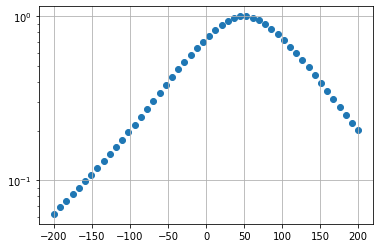

In [36]:
plt.scatter(zz, nu)
plt.yscale("log")
plt.grid()

save the relevant functions to utils module

# Test function from utils

In [6]:
from utils import nu_mond

In [7]:
name = "Baryon"
data_dir = join(root_data_dir, name)
df_baryon = vaex.open(join(data_dir, "baryon.hdf5"))
df_baryon

#,components,rho,e_rho,sigma_z,e_sigma_z
0,Molecular gas (H2),0.0104,0.00312,3.7,0.2
1,Cold atomic gas (HI(1)),0.0277,0.00554,7.1,0.5
2,Warm atomic gas (HI(2)),0.0073,0.0007,22.1,2.4
3,Hot ionized gas (HII),0.0005,3e-05,39.0,4.0
4,Giant stars,0.0006,6e-05,15.5,1.6
...,...,...,...,...,...
7,4 < MV < 5,0.0029,0.00029,18.0,1.8
8,5 < MV < 8,0.0072,0.00072,18.5,1.9
9,MV > 8,0.0216,0.0028,18.5,4.0
10,White dwarfs,0.0056,0.001,20.0,5.0


In [8]:
rhos = df_baryon["rho"].to_numpy()  # Msun/pc^3
sigmaz = df_baryon["sigma_z"].to_numpy() # km/s

# test the following dark values
mu0 = 0.7
R = 3.4E-3 # Msun/pc^3
nu0 = 1
zsun = -0
sigma_w = np.array([20])
a_raw = np.array([1])
w0 = 0.5

theta = dict(rhos=rhos, sigmaz=sigmaz, mu0=mu0, nu0=nu0, zsun=zsun, R=R, w0=w0, sigma_w=sigma_w, a=a_raw)

zz = np.linspace(-1000, 1000, 1000)
sigma_v = 5
nu = nu_mond(zz, **theta)
# filter all z for which nu > 0.2
zb = zz[nu < 0.2]
nub = nu[nu < 0.2]

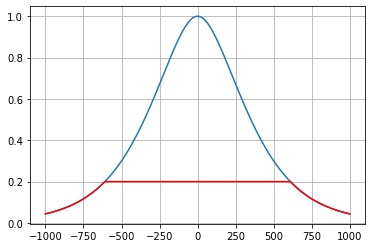

In [9]:
plt.plot(zz, nu)
plt.plot(zb, nub, c="r")
plt.grid()